### imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [87]:
from config.model_config import DATASET_CONFIG, PREPROCESS_CONFIG
from preprocess.preprocess_tools import STFT, Scaler
import preprocess.utility as sp
import numpy as np
import os
import torch
import norbert
from train.model import LSTM_Model
import librosa as lib
# matplotlib for graphs
import matplotlib.pyplot as plot
import matplotlib.cm as cm
from IPython.display import Audio, display

### creating instances for preprocessing tools

In [3]:
# transformation object
transform = STFT(sr=DATASET_CONFIG.SR,
                 n_per_seg=DATASET_CONFIG.N_PER_SEG,
                 n_overlap=DATASET_CONFIG.N_OVERLAP)

# Scaler object
scaler = Scaler()

## Loading music file

In [45]:
track_path = r"../samples/Georgia Wonder - Siren/mixture.wav"
# time series data of mixture
data, sr = sp.read(track_path, stereo=True)
print("Mixture file time series data shape: ", data.shape)

data = sp.to_mono(data)
print("Shape of mono mixture time series data: ", data.shape)

Mixture file time series data shape:  (300032, 2)
Shape of mono mixture time series data:  (300032, 1)


## Short time fourier transformation of time series data

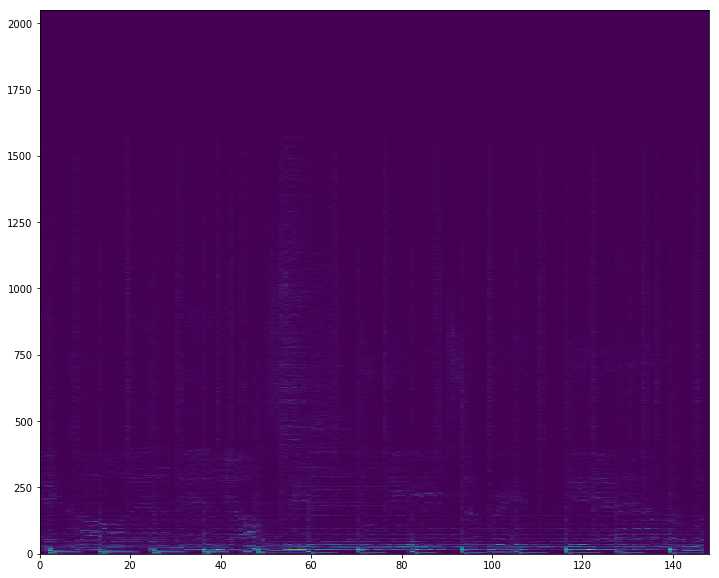

In [46]:
# generate STFT of time series data, shape(nbframes, nb_bins, nb_channels)
mixture_tf = transform.stft(data.T)

# get spectrogram of STFT i.e., |Xi|, shape(nbframes, nb_bins, nb_channels)
mixture_stft = np.abs(mixture_tf)
f, axes = plot.subplots(1, figsize=(12, 10))
axes.pcolormesh(mixture_stft[..., 0].T)

### Checking how normal scaling looks Normal Scaling

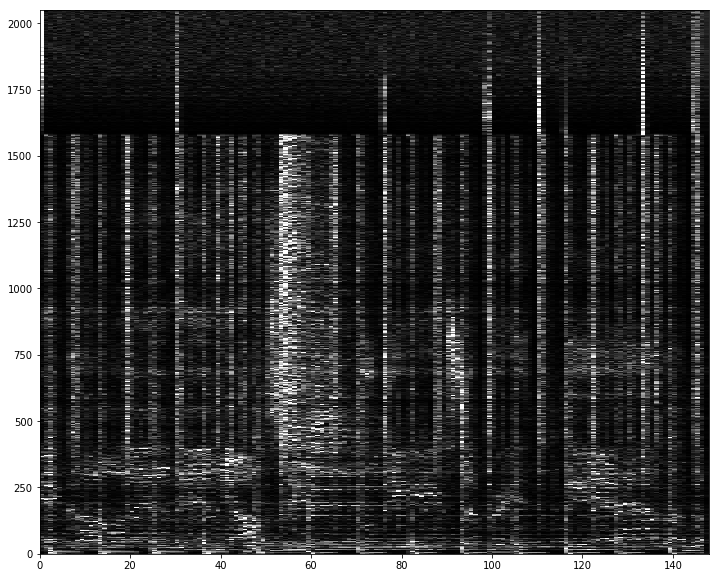

In [94]:
#this is not an actual step its only for demonstration
usual_normalization = lib.util.normalize(mixture_stft)
f, axes = plot.subplots(1, figsize=(12, 10))
plot.pcolormesh(usual_normalization[..., 0].T, cmap=cm.gray)

### Scaling/Normalizing transformed data

Scaled data shape : (148, 2049, 1)
Scaled data min : 1.0
Scaled data max : 1.0
Scaled data mean : 0.14635775556206318


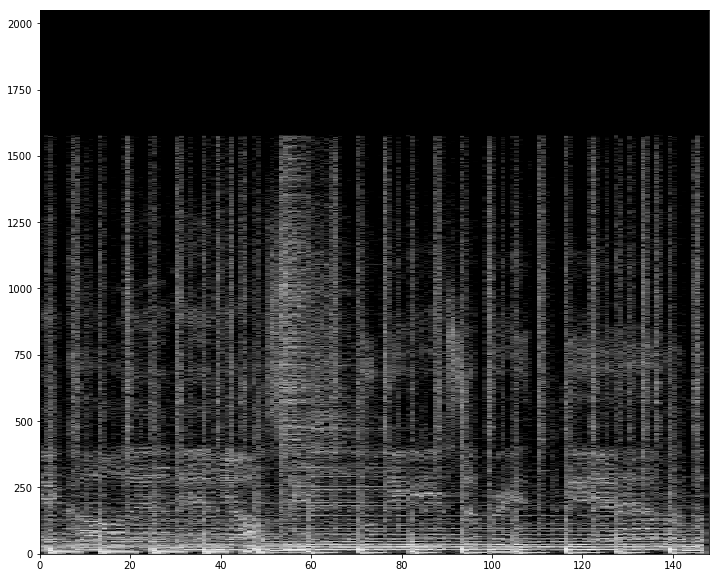

In [95]:
# scaling the values to 0 to 1, shape(nbframes, nb_bins, nb_channels)
X_scaled = scaler.scale(mixture_stft)
print("Scaled data shape :", X_scaled.shape)
print("Scaled data min :", np.max(X_scaled))
print("Scaled data max :", np.max(X_scaled))
print("Scaled data mean :", np.mean(X_scaled))

f, axes = plot.subplots(1, figsize=(12, 10))
plot.pcolormesh(X_scaled[..., 0].T, cmap=cm.gray)

In [96]:
# transposing the matrix to make it in shape (nb_batch, nb_frames, nb_bins)
X_scaled = np.transpose(X_scaled, (2, 0, 1))

## Loading model and predicting the results

In [105]:
# loading the model
path = r'H:\FYP\application\controllers\models\lstm.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dnn_model = torch.load(path, map_location='cpu')
dnn_model.to(device)
dnn_model.eval()

C:\Program Files\Python372\lib\site-packages\torch\serialization.py:435: SourceChangeWarning: source code of class 'train.model.LSTM_Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


LSTM_Model(
  (fc_dr): Linear(in_features=2049, out_features=256, bias=True)
  (lstm): LSTM(256, 256, batch_first=True)
  (fc_de): Linear(in_features=256, out_features=2049, bias=True)
)

In [106]:
with torch.no_grad():
    mixture_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device).to(device)
    estimate = dnn_model(mixture_tensor)

## Filtering the results to generate the output

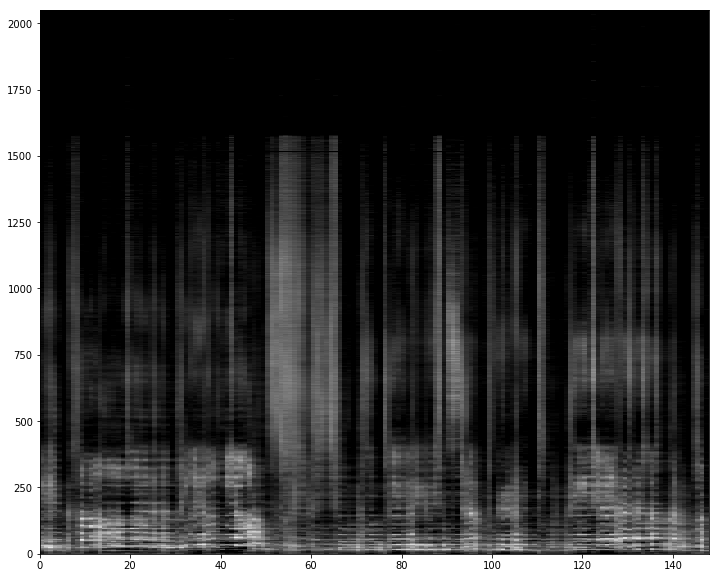

In [107]:
# output tensor shape (nb_batch, nb_frames, nb_bins)
estimate_np = estimate[0].cpu().detach().numpy()

f, axes = plot.subplots(1, figsize=(12, 10))
axes.pcolormesh(estimate_np[...].T, cmap=cm.gray)

In [108]:
# stacking the output to make it in stereo shape
# and transposing it back to shape (nb_frames, nb_bins, nb_channels)
estimate_stereo = np.stack([estimate_np, estimate_np]).transpose(1, 2, 0)
# intensifies the signal
estimate_stereo = estimate_stereo[..., None] ** 2

# stacking the mixture stft to make it in stereo shape
# and transposing it back to shape (nb_frames, nb_bins, nb_channels)
mixture_tf_squeeze = np.squeeze(mixture_tf)
mixture_tf_stereo = np.stack([mixture_tf_squeeze, mixture_tf_squeeze]).transpose(1, 2, 0)

# models the estimates to stft, frequency wise.
estimate_residual = norbert.residual(estimate_stereo, mixture_tf_stereo)
# applying wiener filers to get the sources
estimate_filter_results = norbert.wiener(np.copy(estimate_residual), np.copy(mixture_tf_stereo))

Number of iterations:  2
EM, iteration 1
EM, iteration 2


In [109]:
vocals_estimate = transform.istft(estimate_filter_results[..., 0]).T
acc_estimate = transform.istft(estimate_filter_results[..., 1]).T

In [110]:
display(Audio(acc_estimate.T, rate=44100))
display(Audio(vocals_estimate.T, rate=44100))

In [111]:
print(estimate_filter_results[..., 0].shape)

(148, 2049, 2)


## TESTING Cells

In [112]:
# testing
# output tensor shape (nb_batch, nb_frames, nb_bins)
estimate_np = estimate[0].cpu().detach().numpy()
inverted = np.subtract(1.0, estimate_np)
print(estimate_np[...,None].shape)
print(np.mean(estimate_np))
print(np.max(estimate_np))
print(np.min(estimate_np))
print(mixture_tf.shape)
acc_estimate = mixture_tf*estimate_np[..., None]
res = transform.istft(acc_estimate).T
display(Audio(data.T, rate=44100))
display(Audio(res.T, rate=44100))

(148, 2049, 1)
0.09182671
0.8019538
0.0
(148, 2049, 1)
